# Training of the NN for multiple circles

This notebook is the definition and the training of the NN that predicts PI for the multiple circles dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from IPython.display import SVG

import gudhi as gd
import gudhi.representations

from tqdm import tqdm
import os

### Load the data

In [2]:
data = np.load('data/PI_data_multiple_circle.npz')
#data = np.load('data/PI_data_5000_dynamical.npz')

data_train = data["data_train"]
PI_train = data["PI_train"]
data_test = data["data_test"]
PI_test = data["PI_test"]

In [3]:
N_sets_train = data_train.shape[0]
N_sets_test = data_test.shape[0]
N_points = data_train.shape[1]
PI_size = int(np.sqrt(PI_train.shape[1]))
dim = 2

In [4]:
print("N_sets_train : ", N_sets_train)
print("N_sets_test : ", N_sets_test)
print("N_points : ", N_points)
print("PI_size : ", PI_size)

N_sets_train :  9999
N_sets_test :  999
N_points :  600
PI_size :  50


We normalize the PIs

In [5]:
PI_train /= max(np.max(PI_train), np.max(PI_test))
PI_test /= max(np.max(PI_train), np.max(PI_test))

### Definiton of the NN

In [6]:
class FullyConnected2(tf.keras.layers.Layer):
    def __init__(self, N_input, N_output):
        super(FullyConnected2, self).__init__()
        self.gamma = self.add_weight(name='gamma',
                                     shape=(N_input, N_output),
                                     initializer="random_normal",
                                     trainable=True)

    def call(self, inputs):
        return tf.einsum("ijk,kl->ijl", inputs, self.gamma)

In [7]:
#V2

inputs = tf.keras.Input(shape=(N_points, dim))

#x = tf.keras.layers.Dense(30, activation='relu')(inputs)

FC_layer_2_30 = FullyConnected2(2, 30)
x = FC_layer_2_30(inputs)
x = tf.keras.activations.relu(x)

#x = tf.keras.layers.Dense(35, activation='relu')(x)


x = tf.keras.layers.Dense(20, activation='relu')(x)
#FC_layer_30_20 = FullyConnected2(30, 20)
#x = FC_layer_30_20(x)
#x = tf.keras.activations.relu(x)

x = tf.keras.layers.Dense(10, activation='relu')(x)
#FC_layer_20_10 = FullyConnected2(20, 10)
#x = FC_layer_20_10(x)
#x = tf.keras.activations.relu(x)

Adder = tf.keras.layers.Lambda(lambda x: tf.math.reduce_min(x, axis=1),
                               output_shape=(lambda shape:
                                             (shape[0], shape[2])))
x = Adder(x)
#x = tf.keras.activations.relu(x)

#x = tf.keras.layers.Dense(25, activation='relu')(x)

x = tf.keras.layers.Dense(50, activation='relu')(x)

x = tf.keras.layers.Dense(100, activation='relu')(x)

x = tf.keras.layers.Dense(200, activation='relu')(x)

outputs = tf.keras.layers.Dense(PI_size * PI_size, activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
adam = tf.keras.optimizers.Adamax(
    learning_rate=5e-3)  #5e-3 learning_rate optimal d'après moi
model.compile(optimizer=adam, loss="mse")  #contrastive_loss

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 2)]          0         
_________________________________________________________________
fully_connected2 (FullyConne (None, 600, 30)           60        
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 600, 30)           0         
_________________________________________________________________
dense (Dense)                (None, 600, 20)           620       
_________________________________________________________________
dense_1 (Dense)              (None, 600, 10)           210       
_________________________________________________________________
lambda (Lambda)              (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                550   

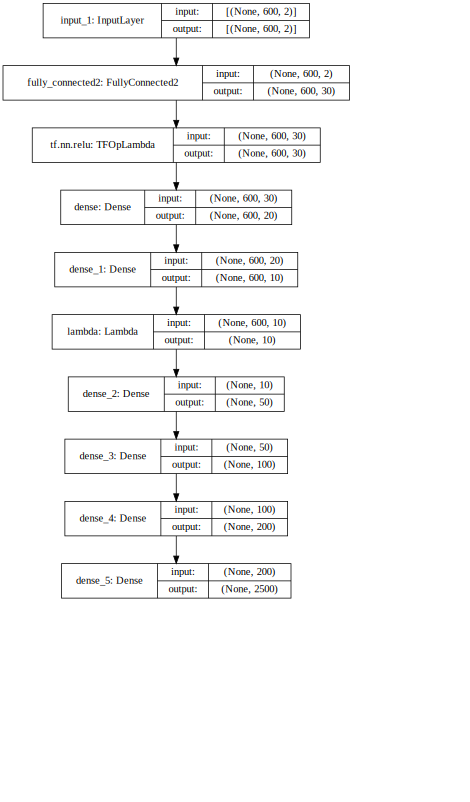

In [8]:
model.summary()

SVG(
    tf.keras.utils.model_to_dot(model, show_shapes=True).create(prog='dot',
                                                                format='svg'))
                                                         
#tf.keras.utils.plot_model(model,
#                          to_file='Résultats/Résultats 2/model_multiple_circles.pdf',
#                          show_shapes=True)

### Training the model 

In [9]:
history = model.fit(data_train,
                    PI_train,
                    epochs=100,
                    validation_data=(data_test, PI_test))


Epoch 1/100
313/313 [==============================] - 4s 10ms/step - loss: 0.0128 - val_loss: 0.0055
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 4/100
313/313 [==============================] - 3s 9ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 5/100
313/313 [==============================] - 3s 9ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/100
313/313 [==============================] - 3s 9ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/100
313/313 [==============================] - 3s 9ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 10/100
313/313 [==============================] - 3s 9ms/step - loss: 0.0024 - val_l

We can save the model

In [15]:
model.save('Saved_Model/model_2_multiple_cricles')

INFO:tensorflow:Assets written to: Saved_Model/model_2_multiple_cricles/assets


### Study the results to see how the training went 

In [10]:
prediction = model.predict(data_test)

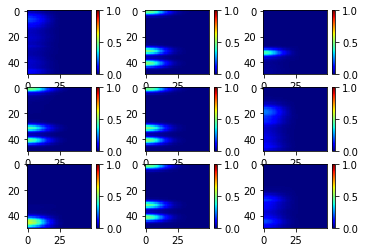

In [11]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.flip(np.reshape(prediction[10 + i], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
    plt.colorbar()
    
plt.suptitle('The corresponding predicted PI')
#plt.savefig("Résultats/Résultats 2/multiple_circles_predicted.pdf")

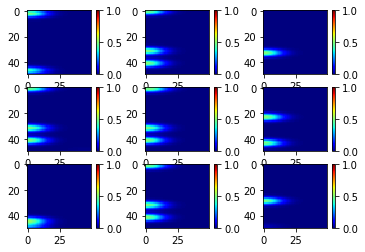

In [12]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.flip(np.reshape(PI_test[10 + i], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
    plt.colorbar()

plt.suptitle('The corresponding true PI')
#plt.savefig("Résultats/Résultats 2/multiple_circles_true.pdf")

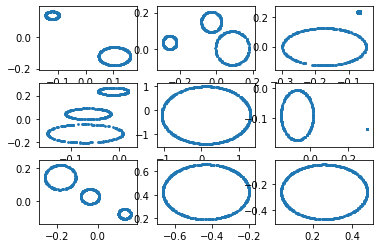

In [9]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.scatter(data_test[10 + i, :, 0], data_test[10 +i, :, 1], s=3)

plt.suptitle('The corresponding point cloud')
#plt.savefig("Résultats/Résultats 2/multiple_circles.pdf")

### Evaluation of the model and plot of the evolution of the loss 

MSE on the test data

In [13]:
(np.square(prediction - PI_test)).mean(axis=None)

0.0016869330690238381

In [14]:
loss = model.evaluate(data_test, PI_test, verbose=1)

32/32 [==============================] - 0s 3ms/step - loss: 0.0017


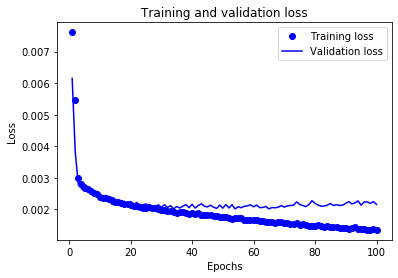

In [13]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs[:], loss[:], 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs[:], val_loss[:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#plt.savefig("Résultats/Résultats 2/training_loss.pdf")
plt.show()

## Classifier

In [31]:

data = np.load('data/PI_data_multiple_circle_classif.npz')

label_classif_train = data["label_train"]
data_classif_train = data["data_train"]
label_classif_test = data["label_test"]
data_classif_test = data["data_test"]


In [32]:
for i in range(len(data_classif_train)):
    data_classif_train[i] = (data_classif_train[i] - np.mean(data_classif_train[i]))/np.var(data_classif_train[i])
for i in range(len(data_classif_test)):
    data_classif_test[i] = (data_classif_test[i] - np.mean(data_classif_test[i]))/np.var(data_classif_test[i])

In [33]:
label_classif_train -= 1
label_classif_test -= 1

In [38]:
inputs = tf.keras.Input(shape=(PI_size * PI_size))

x = tf.keras.layers.Dense(100, activation='relu')(inputs)

x = tf.keras.layers.Dense(50, activation='relu')(x)

outputs = tf.keras.layers.Dense(3)(x)

model_classif = tf.keras.Model(inputs=inputs, outputs=outputs)
model_classif.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])


In [39]:
PI_train_predicted = model.predict(data_classif_train)
PI_test_predicted = model.predict(data_classif_test)


In [40]:
history_classif = model_classif.fit(PI_train_predicted,
                                  label_classif_train,
                                  epochs=100,
                                  validation_data=(PI_test_predicted, label_classif_test))

Epoch 1/100
32/32 [==============================] - 0s 5ms/step - loss: 0.8203 - accuracy: 0.6236 - val_loss: 0.6299 - val_accuracy: 0.7677
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.7307 - val_loss: 0.5165 - val_accuracy: 0.7576
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5739 - accuracy: 0.7528 - val_loss: 0.4946 - val_accuracy: 0.7374
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5445 - accuracy: 0.7728 - val_loss: 0.4711 - val_accuracy: 0.7778
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.5158 - accuracy: 0.7828 - val_loss: 0.4775 - val_accuracy: 0.7374
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4920 - accuracy: 0.7848 - val_loss: 0.4617 - val_accuracy: 0.7778
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.4860 - accuracy: 0.7888 - val_loss: 0.4629 - val_accuracy: 0.7576
Epoch 8/100
3

Epoch 59/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3809 - accuracy: 0.8308 - val_loss: 0.3883 - val_accuracy: 0.8283
Epoch 60/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3939 - accuracy: 0.8288 - val_loss: 0.4231 - val_accuracy: 0.8081
Epoch 61/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3784 - accuracy: 0.8288 - val_loss: 0.3949 - val_accuracy: 0.8081
Epoch 62/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3745 - accuracy: 0.8308 - val_loss: 0.3985 - val_accuracy: 0.8081
Epoch 63/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3672 - accuracy: 0.8398 - val_loss: 0.4136 - val_accuracy: 0.8283
Epoch 64/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3878 - accuracy: 0.8248 - val_loss: 0.4216 - val_accuracy: 0.8081
Epoch 65/100
32/32 [==============================] - 0s 3ms/step - loss: 0.3817 - accuracy: 0.8328 - val_loss: 0.3982 - val_accuracy: 0.8081
Epoch 

In [41]:
test_loss, test_acc = model_classif.evaluate(PI_test_predicted,
                                                label_classif_test,
                                                verbose=2)

print('\nTest accuracy:', test_acc)

4/4 - 0s - loss: 0.3829 - accuracy: 0.8283

Test accuracy: 0.8282828330993652


Accuracy of the classifier trained on Gudhi : 97%


| Number of point clouds for training 	| Accuracy 	|
|:-----------------------------------:	|:--------:	|
|                 100                 	|      42%    	|
|                 500                 	|     80%     	|
|                 750                 	|     84%     	|
|                 1000                 	|     82%     	|
|                 5000                 	|     89%     	|
|                 10000                	|    90%      	|


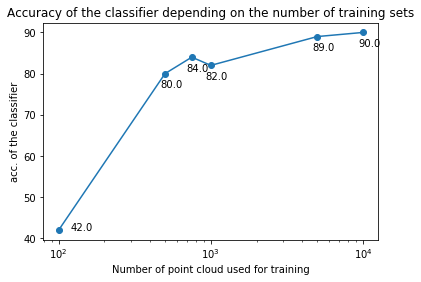

In [9]:
acc = [42,80,84,82,89,90]
number_sets = [100,500,750,1000,5000,10000]

plt.plot(number_sets,acc,'o-')
plt.title("Accuracy of the classifier depending on the number of training sets")
plt.ylabel("acc. of the classifier")
plt.xlabel("Number of point cloud used for training")
plt.xscale('log')

plt.annotate("42.0", # this is the text
             (100,42), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(12,0), # distance from text to points (x,y)
             ha='left') # horizontal alignment can be left, right or center


for x,y in zip(number_sets[1:],acc[1:]):

    label = "{:.1f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-5,-14), # distance from text to points (x,y)
                 ha='left') # horizontal alignment can be left, right or center

#plt.savefig("Résultats/Résultats 4/acc_number_training_set_multi_circles.pdf")
